# Spam filtering using TF-IDF on a Bag of Words model
_Note to reader: You're currently reading the work of a single contributor. I recommend visiting [Matt's](https://github.com/xiaozhang-github/DST-Assessment-3/tree/main/Matt%20Corrie) and [Xiao's](https://github.com/xiaozhang-github/DST-Assessment-3/tree/main/Xiao%20Zhang) works after reading this file. Thank you!_

In this project my teammates and I tackle the issue of constructing a spam filter via the means of topic modelling and topic selection. For this purpose we'll be making use of the enron e-mails available to the public free of charge, which can be found and downloaded from [here](https://github.com/xiaozhang-github/DST-Assessment-3/blob/main/Data/All%20enron.zip). Alternatively, the unzipped version can be found [here](https://github.com/xiaozhang-github/DST-Assessment-3/tree/main/Data/All%20enron%20unzip). 

**Important:** For running this code, the reader is asked to download the provided sources from either of the links (and those only!). Once downloaded and saved, the files should already be placed in a single folder, containing 5 subfolders called 'enron1' through 'enron6' - with 'enron4' missing on purpose. This folder, for ease of access, should either be called 'All enron unzip' or 'All enron'. The user will be asked to _stick with either of those names, preferrably the former_. The importance of this will become apparent shortly.


Our team was tasked with detection of spam on an already categorized sample. The e-mails found in the 'enron' folders are divided between spam(Spam activity) and ham(Normal activity). For the purpose of this project, this knowledge will be used at the end for measuring the accuracy of our outcomes. Our team's approach was trying 3 different topic modelling techniques to separate spam from normal activity. My work deals with a **TF-IDF** (Term Frequency - Inverse Document Frequency) approach, whereas my colleagues took an **LDA** (Latent Dirichlet Allocation) strategy. The performance of these methods will be compared at the end of the project. Mainly, this paper will operate by the following steps:

1) Pre-requisites, k-fold CV and EDA

2) Data Cleaning + Lemmatization

3) An attempt at manual implementation of TF-IDF

4) TF-IDF 

5) Choosing the optimal solution + Accuracy analysis

6) An aside on replies/forwards + Conclusions

7) References


The following libraries will be crucial to our work:

In [1]:
import glob
import os
import re
import random
import numpy as np
import pandas as pd
import math
from pathlib import Path
import matplotlib.pyplot as plt

import gensim
import pickle
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

## 1. Pre-requisites, k-fold CV and EDA

The user is asked to change their working directory accordingly - corresponding to where the folder 'All enron unzip' or 'All enron' was saved on their device. To do so, uncomment the following line (delete the #) and change 'D://Datasets' to your location.

In [2]:
# os.chdir("D://Datasets")

If the folder was saved as 'All enron' or anything else apart from 'All enron unzip', please either rename it to 'All enron unzip'; or, altenatively, modify the next piece of code accordingly.

In [3]:
corpus = []

for path in Path('All enron unzip').rglob('*.txt'):
        with open(path, errors='ignore') as f_input:
            corpus.append(f_input.read())

Let us save the dataframe in a variable and have a first look at it:

In [4]:
df = pd.DataFrame(corpus)
df.head()

,0
0,Legitimate\n----------\n- Owner: farmer-d\n- T...
1,Subject: christmas tree farm pictures\n
2,"Subject: vastar resources , inc .\ngary , prod..."
3,Subject: calpine daily gas nomination\n- calpi...
4,Subject: re : issue\nfyi - see note below - al...


How much data is there to work with?

In [5]:
len(df)

27721

Looking over the subfolders 'enron', one will notice that apart from spam/ham division they all contain an extra file named 'Summary' which offers useful information regarding the division. That is superfluous to our analysis so we'll remove it:

In [6]:
df = df.drop([0,5173,11031,16544,21720]) # Removed the summary bits
df.columns=["E-mails"]

As we mentioned in the introduction, it will be useful at the end to know which e-mails were in fact spam and which weren't. We'll hence create an additional binary feature cataloguing this aspect. This column will never be used to deduce anything and we'll act as if it wasn't there - only being used at the end for accuracy measurement: 

In [7]:
z1 = np.arange(3673,5173)
z2 = np.arange(9534,11031)
z3 = np.arange(15043,16544)
z4 = np.arange(18043,21719)
z5 = np.arange(23220,27716)
ze = np.concatenate((z1,z2,z3,z4,z5))

z = np.zeros(27716)
df['spam'] = z
for i in ze:
    df.iloc[i,1] = 1 # 1 for spam, 0 for ham

We'll now proceed to arbitrarily sample out dataset to avoid all spams being clustered together and all hams as well, since they were that way in the initial format. We will also define an useful floor function as a pre-requisite to k-fold cross validation(CV) for k=10; since we don't have a multiple of 10 datapoints.

In [8]:
random.seed(a=5)
df = df.sample(frac=1)	# Shuffle the entire dataframe
ten_off_df = math.floor(len(df)/10)

The sampled result:

In [9]:
df.head(10)

,E-mails,spam
5065,Subject: it ' s not working like it used to ?\...,1.0
3773,Subject: stop the aging clock\nnerissa\n,1.0
21203,Subject: microsoft windows xp professional wit...,1.0
935,"Subject: last check\ndarren ,\nplease review t...",0.0
17489,Subject: confirmcorp info\nsee the comment bel...,0.0
11832,Subject: re : report for louise\nhey there ! c...,0.0
20198,Subject: save your money buy getting this thin...,1.0
27396,Subject: contact me asap\nnostradamus tour,1.0
22644,Subject: re : conocoprojreqform . xls / monume...,0.0
7973,Subject: fw : enron contact info\nvince and je...,0.0


The following attempt is only presented for record purposes:

In [10]:
#################[Failed FOR loop attempt]
# df_temp = df
# for i in range(1,9):
 #    locals()['df_{}.index.values'.format(i)] = df_temp.sample(ten_off_df)
 #    c_df = locals()['df_{}'.format(i)]
 #    locals()['l_{}'.format(i)] = list(c_df.index.values)
 #    loc_l = locals()['l_{}'.format(i)]
 #    df_temp = df_temp.drop(loc_l)

_This_ attempt executes the 10-fold cross validation, creating 9 sub-dataframes df_0 through df_8 which will together form our training set: 

In [11]:
################# [Good For loop attempt]
df_temp = df
for i in range(0,9):
    a = df_temp.sample(ten_off_df)
    locals()['df_{}'.format(i)] = a
    l = list(a.index.values)
    df_temp = df_temp.drop(l)

We now create the test and training sets correspondingly:

In [12]:
df_test = df_temp

frames=[df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8]
df_train = pd.concat(frames)

A quick test to see if the split has been done properly:

In [13]:
len(df_train)+len(df_test)==len(df)	## Check if the split was properly done

True

We will import a list of commonly used words in english with the following code. These words will then be eliminated from the e-mails as part of the data cleaning process. Uncomment the 3rd line if the file wasn't already pre-downloaded on your device:

In [14]:
import nltk
from nltk.corpus import stopwords

# nltk.download('stopwords')

In [15]:
df_test

,E-mails,spam
18999,Subject: sitescooper : scoop websites onto you...,1.0
22109,Subject: el paso order on complaint\nattached ...,0.0
17507,Subject: final\nthis is absolutely the final r...,0.0
23102,Subject: kase and company derivatives for ener...,0.0
22435,Subject: tw transportation contract # 25374\nm...,0.0
...,...,...
1197,"Subject: re : preliminary "" buyback & deficien...",0.0
26732,Subject: unique - logos ! ( 85124799 )\ndoes y...,1.0
20398,Subject: tiffany hypes ' s internet address fo...,1.0
1902,Subject: re : meter 0980438 - acock production...,0.0


In [16]:
df_train

,E-mails,spam
550,Subject: re : teco gas processing company\n- -...,0.0
23398,"Subject: if you suffer from depression , try v...",1.0
5666,Subject: the storage revolution has begun\nnet...,0.0
18685,"Subject: let us "" show you the money ! ""\nrece...",1.0
9992,Subject: it ' s mariah from dating service\ni ...,1.0
...,...,...
27268,Subject: boing . . . ( the sound produced by a...,1.0
12819,Subject: fyi - bod agenda deadlines\nthe next ...,0.0
23533,Subject: fashion boys for every taste ! noode ...,1.0
26946,Subject: successful judgment recovery business...,1.0


An interesting aspect of e-mails is that a large number of them are either in the form of replies (or, more advanced, reply chains) or forwarded to/from someone else. They're not always single one-to-one conversations. This creates sensible suggestions of possible repetitiveness of some words or phrases/syntagms for the duration of the reply chain. We will first visualize how many such e-mails are present in our data and then study them independently at the end of our analysis. For the main analysis, however, we will treat them with no extra weighted importance.

The following code separates them from each df_n subset as well as from the main training set:

In [17]:
df_0_ok = df_0[df_0['E-mails'].str.contains("re :") | df_0['E-mails'].str.contains("fw :")]
df_1_ok = df_1[df_1['E-mails'].str.contains("re :") | df_1['E-mails'].str.contains("fw :")]
df_2_ok = df_2[df_2['E-mails'].str.contains("re :") | df_2['E-mails'].str.contains("fw :")]
df_3_ok = df_3[df_3['E-mails'].str.contains("re :") | df_3['E-mails'].str.contains("fw :")]
df_4_ok = df_4[df_4['E-mails'].str.contains("re :") | df_4['E-mails'].str.contains("fw :")]
df_5_ok = df_5[df_5['E-mails'].str.contains("re :") | df_5['E-mails'].str.contains("fw :")]
df_6_ok = df_6[df_6['E-mails'].str.contains("re :") | df_6['E-mails'].str.contains("fw :")]
df_7_ok = df_7[df_7['E-mails'].str.contains("re :") | df_7['E-mails'].str.contains("fw :")]
df_8_ok = df_8[df_8['E-mails'].str.contains("re :") | df_8['E-mails'].str.contains("fw :")]
df_train_ok = df_train[df_train['E-mails'].str.contains("re :") | df_train['E-mails'].str.contains("fw :")]

## Based on the nature of spam e-mails, this simple filter has some good accuracy but not 100%

In [18]:
df_0_ok

,E-mails,spam
550,Subject: re : teco gas processing company\n- -...,0.0
5666,Subject: the storage revolution has begun\nnet...,0.0
18685,"Subject: let us "" show you the money ! ""\nrece...",1.0
14999,Subject: fw : fw : canadian legal entity\nfyi\...,0.0
12306,Subject: re : eol mobile access\nlouise did lo...,0.0
...,...,...
2655,Subject: re : noms / actual flow for 03 / 01\n...,0.0
6158,"Subject: re : resume\nthanks , vince - -\nvinc...",0.0
2745,"Subject: re : exxon company , usa global # 960...",0.0
250,Subject: fw : whose needs ? ? ? ? ? ? ? ?\n> p...,0.0


Let's now use some EDA to visualise these e-mails. Note that due to the nature of the e-mails and the method we used to separate them, a couple of non-reply non-forward e-mails have gotten their way through as well. However, the quantity of those is irrelevant to our study:

In [19]:
for i in range(0,9):
    locals()['y_{}'.format(i)] = np.array([len(locals()['df_{}_ok'.format(i)]), len(locals()['df_{}'.format(i)]) - len(locals()['df_{}_ok'.format(i)])])

y=np.array([len(df_train_ok), len(df_train)-len(df_train_ok)])

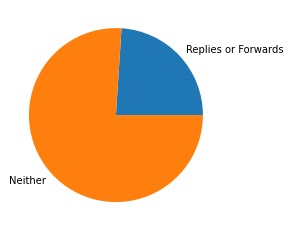

In [20]:
plt.pie(y, labels=["Replies or Forwards", "Neither"])
plt.show()

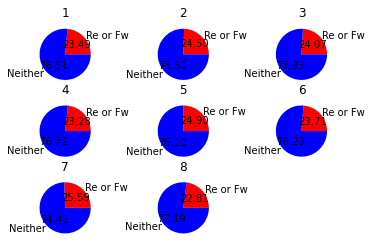

In [21]:
for i in range(1,9):
    plt.subplot(3,3,i)
    plt.pie(locals()['y_{}'.format(i)], labels=["Re or Fw", "Neither"], autopct = '%.2f', colors = ['red', 'blue']) 
    plt.title('{}'.format(i))
    
plt.show()    

This concludes our pre-requisites. We may now move on to the data cleaning process:

## 2. Data Cleaning + Lemmatization

Using the stopwords previously downloaded in stage 1, we aim to store them in a list. Moreover, if they were to be removed as such from out dataset, they would unfortunately be removed wherever their corresponding characters were found in the sequence forming the word, which is needless to say undesirable. For example, if the word 'red' was in the sequence not only would 'red' be removed from all e-mails; -- but if the word 'accreditation' or 'predict' featured in the e-mails somewhere, the word 'red' would be identified within them so they'd be reduced to 'accitation' and 'pict' respectively. And this is just one example of such mistake. The list notably contains a couple of single letters as well, such as 's', 't' and 'r' (for reasons unapparent to us), so they would all be removed as characters from everywhere in the e-mails. This would certainly make the e-mails unreadable and result in great discomfort for our models.

The solution I chose was to spatiate both before and after the word, so that only it will ever be removed. This does leave the option of the word being the last or the first in a sentence - which unfortunately resulted in a number of errors - and the upside wasn't encountered often enough to justify the complication of our method. The proposal of this more advanced thought has been commented however. We will also remove the string 'Subject:' featuring at the start of every conversation:

In [22]:
l1 = stopwords.words('english')
lst1 = [' {} '.format(x) for x in l1]
lst1.append('Subject:')
lst1.append('Subject :')
lst1.remove(' re ')
# lst2 = [ '.{} '.format(x) for x in l1]
# lst3 = [ ' {}.'.format(x) for x in l1]

We now remove this list of common words from all e-mails:

In [23]:
# Remove too common words from the list we procurred:
for i in range(0,9):
    locals()['df_{}'.format(i)]['E-mails'].replace(lst1, " ", regex=True, inplace=True)
    
   #  locals()['df_{}'.format(i)]['E-mails'].replace(lst2, " ", regex=True, inplace=True)
   #  locals()['df_{}'.format(i)]['E-mails'].replace(lst3, " ", regex=True, inplace=True)
df_train['E-mails'].replace(lst1, " ", regex=True, inplace=True)
df_test['E-mails'].replace(lst1, " ", regex=True, inplace=True)

Similarily, punctuation plays no positive role to topic modelling, though helpful to us as humans. We will remove most of it, particularly so the commonly used characters:

In [24]:
# Remove punctuation and often used symbols
# "[?!.,;()"\/|&-`#$%^]"
for i in range(0,9):
    locals()['df_{}'.format(i)]['E-mails'].replace(r'[^\w\s]', " ", regex=True, inplace=True)
    
df_train['E-mails'].replace(r'[^\w\s]', " ", regex=True, inplace=True)
df_test['E-mails'].replace(r'[^\w\s]', " ", regex=True, inplace=True)

Although some scam e-mails were in the form of 'You just won 1000000 dollars!', it's fair to say a model will detect other terms as being relevant without the numerical value. Otherwise, numbers as a whole are just as irrelevant as punctuation to our work so we'll remove them too:

In [25]:
# Remove all numbers from the e-mails, as they're (mostly) redundant
# "[0-9999999999]"

for i in range(0,9):
    locals()['df_{}'.format(i)]['E-mails'].replace('[0-9999999999]', " ", regex=True, inplace=True)

df_train['E-mails'].replace('[0-9999999999]', " ", regex=True, inplace=True)
df_test['E-mails'].replace('[0-9999999999]', " ", regex=True, inplace=True)

Let us take a look at what we've accomplished so far:

In [26]:
df_train

,E-mails,spam
550,re teco gas processing company\n ...,0.0
23398,suffer depression try valium xanax cance...,1.0
5666,storage revolution begun\nnetwork world fusi...,0.0
18685,let us show money \nreceive total ...,1.0
9992,mariah dating service\ni mariah girl n...,1.0
...,...,...
27268,boing sound produced little pill \n...,1.0
12819,fyi bod agenda deadlines\nthe next bod com...,0.0
23533,fashion boys every taste noode boys allso ...,1.0
26946,successful judgment recovery business\nvery ...,1.0


In [27]:
df_test

,E-mails,spam
18999,sitescooper scoop websites onto palmpilot ...,1.0
22109,el paso order complaint\nattached summary el...,0.0
17507,final\nthis absolutely final rewrite letter ...,0.0
23102,kase company derivatives energy professional...,0.0
22435,tw transportation contract \nmichelle...,0.0
...,...,...
1197,re preliminary buyback deficiency deal...,0.0
26732,unique logos \ndoes company ...,1.0
20398,tiffany hypes internet address life \nhi ...,1.0
1902,re meter acock production ...,0.0


We'll test a random subset too, say the 5th one:

In [28]:
df_4

,E-mails,spam
9480,transportation gillis g whitaker post pr...,0.0
22913,re lateral space\n proprietary \nmic...,0.0
1161,update prc process\nplease read attached mem...,0.0
9145,re pending approval ibuyit request wincent...,0.0
4003,barely age ready company\nclick removed\n,1.0
...,...,...
24994,payyless mlcrosoft streets trips \npay l...,1.0
9472,schedule\nvince \nmy schedule risk con...,0.0
11143,peoples energy board directors\non april ...,0.0
5423,re additional bloomberg terminal weather g...,0.0


We will now define a tokenizer, which we'll use to separate words in the lists of e-mails. We then proceed to lemmatize:

In [29]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

This function does the lemmatization:

In [30]:
# nltk.download('wordnet')
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

We apply it on our datasets:

In [31]:
for i in range(0,9):
    locals()['df_{}_lem'.format(i)] = locals()['df_{}'.format(i)]['E-mails'].apply(lemmatize_text)

df_train_lem = df_train['E-mails'].apply(lemmatize_text)
df_test_lem = df_test['E-mails'].apply(lemmatize_text)

This is the result:

In [32]:
df_train_lem

550      [re, teco, gas, processing, company, forwarded...
23398    [suffer, depression, try, valium, xanax, cance...
5666     [storage, revolution, begun, network, world, f...
18685    [let, u, show, money, receive, total, cash, bo...
9992     [mariah, dating, service, i, mariah, girl, nex...
                               ...                        
27268    [boing, sound, produced, little, pill, control...
12819    [fyi, bod, agenda, deadline, the, next, bod, c...
23533    [fashion, boy, every, taste, noode, boy, allso...
26946    [successful, judgment, recovery, business, ver...
20954    [amazzing, news, how, save, precentor, medlcat...
Name: E-mails, Length: 24939, dtype: object

We will now try to implement TF-IDF on the lemmatized dataframes ourselves:

## 3. An attempt at manual implementation of TF-IDF

We will first have a go at a manual implementation of TF-IDF. We will follow the formulae closely. Firstly, to obtain TF, we compute how many times a term appears in a given document per all documents, and then divide by the number of terms in the document. This analysis can be extended for every of our datasets, but we'll mostly work with the large, training set one.

Firstly, let's assign all the words in every individual document to a list and mark the datasets as a list of those lists. This will retain the initial length of the dataset while essentially transforming its type to a list:

In [60]:
## All words used in df_n's:
for i in range(0,9):
    locals()['d{}'.format(i)] = locals()['df_{}'.format(i)].stack().str.split("[^\w+]").explode().tolist()

dftrain = df_train['E-mails']
dftrain = pd.DataFrame(dftrain, columns=['E-mails'])
dftrain = df_train.stack().str.split("[^\w+]").explode().tolist()
## Ignore the warnings please

As we said, the following analysis could be done for all datasets, but we'll work with the main training one. We will do 3 things:

1) Remove the null indentings which were extra added to the lists. These were due to the nature of our data cleaning and fully expected.

2) We'll remove all words of fewer than 4 characters, since most of them are unimportant.

3) Lastly, we'll get a list of all **unique** words in every document -- which will essentially act as our dictionary.

We will then be able to look for terms in the assigned dictionary, knowing that nothing exists outside of it:

Let us read the resulting dictionary:

In [ ]:
## Remove the identings
# for i in range(0,9):
  #   locals()['d{}'.format(i)]= list(filter(None, locals()['d{}'.format(i)])) # our 'bag of words'
    ## Remove fewer than 4 characters terms
  #   locals()['d{}'.format(i)] = [token for token in locals()['d{}'.format(i)] if len(token)>4]
    ## Read unique terms => dictionary
   #  locals()['d{}_u'.format(i)] = np.unique(locals()['d{}'.format(i)]) # our dictionary, finally!

dftrain = list(filter(None, dftrain))
dftrain_u = []
for n in dftrain:
    try:
        if(len(n)>4):
            dftrain_u.append(n)
    except:
        pass
        
# dftrain = [n for n in dftrain if len(n)>4]
dftrain_u = np.unique(dftrain_u)

In [ ]:
dftrain_u

We don't expect too many words in comparison with the total number of words, since most were repeated.

In [264]:
len(dftrain_u)

100589

We now define a function reading the number of occurences:

In [34]:
def countX(lst, x): 
    return lst.count(x)

Finally, it's time to compute the number of occurences of each term in the documents, i.e. in every sublist of our list of words. The words are picked from the dictionary and looped through every list.

**DISCLAIMER:** The following piece of code may take beyond 1h to run. This is due to an O(n^2) complexity with a pretty large n. The user may choose to skip this and jump straight to the result, which we offer a quick check of validity for. Moreover, this will turn out to be _unimportant_ in our final discoveries and proper implementation, i.e. this entire section is more or less optional to the project, mainly kept for record.

In [266]:
## WARNING: Immense runtime expected, ~ 1 hour 
v = np.zeros(len(dftrain))
i = 0
for x in dftrain_u:
    v[i] = countX(dftrain,x)
    i = i + 1

Finally, we print the occurences of every term:

In [268]:
v ## Number of occurences of every element
len(v)

2620892

This is _almost_ the TF (Term Frequency). We only need to divide by len(dftrain) - i.e. the total number of terms in the documents. Finally, if we sum over all frequencies we should get a result that's really, really close to 1, since the words exhaustively describe the dictionary. The arbitrary Epsilon +/- from 1 is just random noise from the computation.

In [270]:
v1 = v/len(dftrain) 
	## This stores the term frequencies of all terms in dftrain
	## They're stored in indices corresponding to the indices of df1_u, i.e. v1[i] is the term frequency of term on the ith position in df1_u
sum(v1) # should be very, VERY close to 1

1.000000000000923

To implement the IDF(Inverse Document Frequency) we use a very similar strategy. We'll define a function which simply mathematically follows the formula of IDF implementation:

In [ ]:
## Define IDF
def computeIDF(docList):
    idfDict = {}
    N = len(docList)
    idfDict = dict.fromkeys(docList[0].keys(), 0)
    for doc in docList:
        for word, val in doc.items():
            if val>0:
                idfDict[word] = idfDict[word] + 1
    for word, val in idfDict.items():
        idfDict[word] = math.log10(N/float(val))
    return idfDict

Seeing how long TF took to run, it is clear by complexity that IDF will take even longer. This function is unadvisable for large datasets, and certainly unsuited for ours. Neither was our manual TF implementation. Hence, to avoid carrying this kind of code around to our accuracy report and visualisation, we give up and attempt a pre-established route. However, this experiment serves as an important reminder of function optimization!

## 4. TF-IDF

Here we implement the TF-IDF model using gensim. We'll then add it to our report and make it available to the rest of the contributors via the pickle library. To start things off, we'll need the e-mails to be formatted as lists. This is easily done:

In [33]:
for i in range(0,9):
    locals()['df_{}_lem_list'.format(i)] = locals()['df_{}_lem'.format(i)].values.tolist()

df_train_lem_list = df_train_lem.values.tolist()
df_test_lem_list = df_test_lem.values.tolist()
df_3_lem_list[0:1]

[['request',
  'submitted',
  'access',
  'request',
  'andrew',
  'burk',
  'enron',
  'com',
  'you',
  'received',
  'email',
  'listed',
  'security',
  'approver',
  'please',
  'click',
  'approval',
  'review',
  'act',
  'upon',
  'request',
  'request',
  'id',
  'request',
  'create',
  'date',
  'am',
  'requested',
  'andrew',
  'burk',
  'enron',
  'com',
  'resource',
  'name',
  'eol',
  'u',
  'backoffice',
  'stack',
  'manager',
  'resource',
  'type',
  'application']]

We now ought to create a dictionary. To do so, we will compose it out of all the words in the training set, but remove the words with fewer than or equal to 4 letters in the process.

In [34]:
lister = [[] for x in range(len(df_train_lem))]
for i in range(len(df_train_lem_list)):
    l = df_train_lem_list[i]
    for token in l:
        if len(token)>4:
            lister[i].append(token)

lister[0:1]

[['processing',
  'company',
  'forwarded',
  'george',
  'weissman',
  'smith',
  'eisenhour',
  'george',
  'weissman',
  'wardle',
  'subject',
  'processing',
  'company',
  'still',
  'problem',
  'nominate',
  'forward',
  'meter',
  'please',
  'status',
  'thanks',
  'forwarded',
  'smith',
  'gregory',
  'allen',
  'jackson',
  'eisenhour',
  'smith',
  'george',
  'weissman',
  'subject',
  'processing',
  'company',
  'going',
  'ticket',
  'houston',
  'pipeline',
  'company',
  'anywhere',
  'january',
  'march',
  'houston',
  'pipeline',
  'company',
  'resource',
  'original',
  'stated',
  'think',
  'processing',
  'appear',
  'market',
  'supply',
  'depending',
  'position',
  'please',
  'something',
  'smith',
  'george',
  'weissman',
  'eisenhour',
  'gregory',
  'allen',
  'jackson',
  'subject',
  'processing',
  'company',
  'sitara',
  'reflect',
  'forward',
  'thanks',
  'forwarded',
  'smith',
  'gregory',
  'allen',
  'jackson',
  'jennifer',
  'meador',

We now use gensim and our defined list to create the dictionary

In [35]:
dictionary = gensim.corpora.Dictionary(lister)

Next, the corpus

In [36]:
bow_corpus = [dictionary.doc2bow(doc) for doc in lister]

Finally, we have our model - applied on the corpus on the defined dictionary. These values will have to be modified if we choose a different sample set, i.e. when using the df_test one for instance:

In [37]:
tfidf=gensim.models.TfidfModel(bow_corpus)
tfidf_corp = tfidf[bow_corpus]

In [38]:
bow_corpus[0:1]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 5),
  (6, 1),
  (7, 1),
  (8, 3),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 2),
  (13, 1),
  (14, 3),
  (15, 2),
  (16, 2),
  (17, 1),
  (18, 13),
  (19, 1),
  (20, 1),
  (21, 7),
  (22, 1),
  (23, 1),
  (24, 2),
  (25, 1),
  (26, 1),
  (27, 2),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 2),
  (32, 3),
  (33, 2),
  (34, 1),
  (35, 1),
  (36, 3),
  (37, 1),
  (38, 2),
  (39, 1),
  (40, 1),
  (41, 2),
  (42, 1),
  (43, 1),
  (44, 2),
  (45, 6),
  (46, 1),
  (47, 12),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 5),
  (52, 1),
  (53, 3),
  (54, 1),
  (55, 5),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 2),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 5),
  (69, 1),
  (70, 5),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 2),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 2),
  (79, 2),
  (80, 4),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 11),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91,

We will now have a first attempt at running the model. We expect this one to be heavily suboptimal. Suppose we choose a random number of topics initially, say 6, and see how it performs:

In [39]:
lda_model_tfidf = gensim.models.LdaMulticore(tfidf_corp, num_topics=6, id2word=dictionary, passes=2, workers=4)

To visualise it, we use the following set of code:

In [40]:
# !python -m pip install pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [41]:
lda_display = pyLDAvis.gensim.prepare(lda_model_tfidf, tfidf_corp, 
                                          dictionary, mds='mmds')
pyLDAvis.display(lda_display, template_type='notebook')

The visualisation is supposed to be interactive, as one can look through all topics individually as well as modify lambda, the rate of relevance. However, this feature may be limited by GitHub. To obtain the interactive visualisation, you should run the code in any python environment instead, such as jupyter notebook or anaconda prompt.

To measure our success, we will verify 2 key values of our model: coherence and perplexity. The higher the former, the better; whereas the inverse can be said about perplexity. The following two blocks of code implement these values with ease.

In [42]:
from gensim.models.coherencemodel import CoherenceModel
def getCoherence(m,t,d):
    coherence_model_lda = CoherenceModel(model=m,texts=t, dictionary=d, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return(coherence_lda) # Need high coherence

As for perplexity:

In [43]:
perplex = lda_model_tfidf.log_perplexity(tfidf_corp) # Need low perplexity

Let us see what we get for this arbitrary model:

In [44]:
perplex

-10.946241066342365

In [45]:
getCoherence(m=lda_model_tfidf, t=lister, d =dictionary)

0.4071394171520231

Surprisingly, the values aren't too bad. Perplexity appears to be lower than expected on a random model. Moreover, starting from such a good (low) value, we normally expect perplexity to be strictly decreasing as the number of topics increases, i.e. inversely proportional. Coherence is neither particularly inviting nor repulsive at 0.378. However, we ought to look for better solutions than this one.

## 5. Choosing the optimal solution + Accuracy analysis

To attain an optimal solution, the best way is to test several topics. By that we mean changing the number of topics and analysing how performance is affected via our two main tools described in section 4: coherence and perplexity. We choose to run 50 models, store all the values for their respective coherences and perplexities in 2 vectors, 'gCH' and 'perplexity'.

**DISCLAIMER:** Due to the evidently demanding nature of this part of the project, the runtime for the following 3 blocks of code is expected to be immense. On my personal device, all together, the time of execution varied between 1 hour up to 80 minutes. If you are to choose to skip this part for obvious reasons, you can continue below by simply referring to the results instead. 

In [79]:
### Starting with this, these 3 lines together take a really long time to run ~ aprox 80min for me
gCH = [0] * 50
for i in range(1,50):
    locals()['lda_model_tfidf_{}'.format(i)] = gensim.models.LdaMulticore(tfidf_corp, num_topics=i, id2word=dictionary, passes=2, workers=6)

We will now save the values in the vector:

In [80]:
for i in range(1,50):
    gCH[i]=getCoherence(m=locals()['lda_model_tfidf_{}'.format(i)], t=lister, d =dictionary)

Similarily for perplexity:

In [81]:
perplexity = [0] * 50
for i in range(1,50):
    perplexity[i]=locals()['lda_model_tfidf_{}'.format(i)].log_perplexity(tfidf_corp)

Let's see what we obtained for both vectors:

In [82]:
perplexity # Seems to be decreasing steadily the more topics we try
        ## We hence decide to give much more importance to the coherence aspect

[0,
 -10.120509319599039,
 -10.384096815195484,
 -10.598616464840763,
 -10.816147398057886,
 -10.904427994125875,
 -11.112184867554982,
 -11.395612459622066,
 -11.53106805783743,
 -11.736637536819318,
 -12.00139898353434,
 -12.069549770989154,
 -12.227910719968088,
 -12.50424301143771,
 -12.794297034077422,
 -12.927994631877212,
 -13.123097022558493,
 -13.333787373587372,
 -13.535157344145697,
 -13.748589009838604,
 -13.934098578911094,
 -14.118517465877842,
 -14.37109126168436,
 -14.535149431748831,
 -14.800970460012657,
 -14.989840561273871,
 -15.185068973891417,
 -15.390220589073763,
 -15.657613617634267,
 -15.837875347935368,
 -16.070784373384733,
 -16.27955749232283,
 -16.540087758207317,
 -16.74999743269401,
 -17.032723756265717,
 -17.28429081697981,
 -17.53022405327836,
 -17.808098644274004,
 -18.170862972311504,
 -18.488859807691174,
 -18.723560482399982,
 -19.07710140645974,
 -19.14793887754755,
 -19.739916189684664,
 -20.09035006012123,
 -20.465350712892157,
 -20.776347031108

In [83]:
gCH

[0,
 0.3484184220316184,
 0.36190237280065074,
 0.3508551240976782,
 0.3912397249926828,
 0.36625127614124603,
 0.3904026642399823,
 0.3725546173839312,
 0.36694484588828546,
 0.41955924984130283,
 0.3785121589081709,
 0.41645751813676407,
 0.36351973244062746,
 0.3559154324108398,
 0.345057740033078,
 0.3601210147297158,
 0.4024036055527278,
 0.37565378293780194,
 0.4212153159901123,
 0.35261373767187854,
 0.3952188568384446,
 0.40582660128926923,
 0.3468837455149979,
 0.37836853481335,
 0.37560019391781796,
 0.3985566916180886,
 0.42629608178860995,
 0.42107956172500416,
 0.41932579367193507,
 0.3700790642166274,
 0.4226900701232102,
 0.4312972582907459,
 0.43113188224805604,
 0.39495344617930633,
 0.4183642108497187,
 0.41214993442346193,
 0.4237665145052193,
 0.4268524731396484,
 0.405436458454808,
 0.41647338326209454,
 0.450730717103608,
 0.42785746210697084,
 0.42963615993530313,
 0.45674649295458114,
 0.44448878245052836,
 0.46885074228327756,
 0.45804193269850146,
 0.416378125

Apart from the very first value which measures on 0 topics, which is hence why the result is also 0, all values represent valid measurements. We hence obtained results for between 1 and 49 topics measurements. We can easily check that is the case.

In [84]:
len(gCH)

50

We will also analyse the trend of both variables graphically:

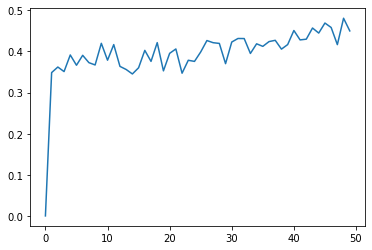

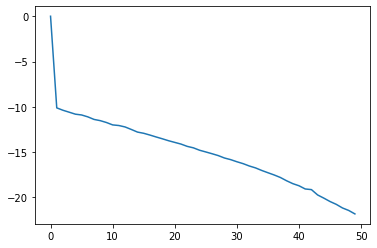

In [85]:
plt.plot(gCH)
plt.show()
plt.plot(perplexity)
plt.show()

Notably, perplexity is, as expected, strictly decreasing as the number of topics increases. Coherence varies; but it starts from much smaller values than it eventually builds up to. One might say that the trend of coherence is in fact to continue increasing as we measure on even more topics - but this would be computationally unadvisable for the purpose of this article. However, users are encouraged to try it out on their own expense! The code to do so would simply be replacing '50' with say '100' at the start of every loop and analysis the results by running identical code to ours afterwards. We seem to have obtained good coherence regardless:

In [86]:
print("The maximum number is", max(gCH), "and its corresponding number of topics is", np.argmax(gCH))

The maximum number is 0.48050945000120243 and its corresponding number of topics is 48


Indeed, 48 topics steadily beats 49 in our particular sample - but this doesn't mean that coherence will certainly only decrease from then onwards, as we saw it fluctuates. Perplexity on the other hand looks quite certainly decreasing, so that's a much safer assumption to make.

Let's therefore display our optimal model:

In [87]:
lda_display_good = pyLDAvis.gensim.prepare(lda_model_tfidf_48, tfidf_corp, 
                                          dictionary, mds='mmds')
pyLDAvis.display(lda_display_good, template_type='notebook')

The above represents TF-IDF's optimal performance/solution. Our team chose to compare our results proportionally on a more simple and less computationall expensive 2-topics model. The main reasoning behind this decision is the nice parallel between the binary Spam/NoSpam category fix and having them (hopefully) segregated by the 2 models.

We will therefore run a very similar analysis (Without computing the coherence and perplexity this time, since we already know them from the list) on 2 models:

In [47]:
lda_model_tfidf_2 = gensim.models.LdaMulticore(tfidf_corp, num_topics=2, id2word=dictionary, passes=2, workers=4)
lda_display_me = pyLDAvis.gensim.prepare(lda_model_tfidf_2, tfidf_corp, 
                                          dictionary, mds='mmds')
pyLDAvis.display(lda_display_me, template_type='notebook')

## We know this has corresponding coherence: gCH[2]= 0.36190237280065074 and corresponding perplexity perplexity[2] = -10.384

We will now compare our predictions with the actual spam v.s ham data we extracted at the very start of the project in section 1. The method will be the identical within our team - so that we can properly compare the results. 

In [51]:
y_pred = [] # model predictions
y_actual = list(df_train['spam']) # list of original classification of spam/normal for the data set

for i in range(0,len(df_train)): # for each document
    for index, score in sorted(lda_model_tfidf_2[tfidf_corp[i]], key=lambda tup: -1*tup[1]): # pull the topic (index) and score (probability) from the model 
        if score >= 0.5 and index == 0: # if the index is 0 and score (read probability) is >0.5 
                                        # assign 0
            y_pred.append(0)
            break
        elif score > 0.5 and index == 1: # same as above for 1
            y_pred.append(1)
            break


These values can be most easily read within a confusion matrix as follows:

In [49]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_eval(y_true,y_pred):
    
    print("Confusion Matrix")
    C = confusion_matrix(y_true,y_pred)
    
    print('Classification report')
    print(classification_report(y_true, y_pred, target_names = ['Normal', 'Spam'], digits=3))

In [52]:
classification_eval(y_actual,y_pred)

Confusion Matrix
Classification report
              precision    recall  f1-score   support

      Normal      0.661     0.787     0.719     13553
        Spam      0.673     0.520     0.586     11386

    accuracy                          0.665     24939
   macro avg      0.667     0.654     0.653     24939
weighted avg      0.666     0.665     0.658     24939



We notice two things:

1) The results aren't particularly good, nor bad. Due to sampling, several accuracy results have been obtained for the duration of this project. The overall performance of the model goes beyond the limited scope of this paper alone, but it is discussed in the conclusions section of the report, which can be found [here](https://github.com/xiaozhang-github/DST-Assessment-3/tree/main/Report). With this being said; running the same model several times obtained accuracies varying from the worst of ~ 55.5% to the best of ~ 78.2%. The result we present is somewhat an average of those. To conduct an actual average of performances, one may run the code in several different seeds at once and take the average. Increasing the number of seeds (and hence, iterations) will hopefully stabilize the result. With this method - which is not replicated here for the purpose of not overloading the user with complexity issues and pointlessly long runtimes - the obtained average was around 68%; which the result we chose to portray is pretty close to.

2) This result is not exactly final. We still need to run a similar analysis on the test sample 'df_test'. However, we confidently expect the results for that one to be lower than for the training set, due to a restricted (smaller) dictionary. Lastly, for comparison with our colleagues, we will take the weighted average of both of these results - since this is what the other contributors essentially did by _not splitting_ their data.

Firstly, let us complete the analogous analysis for df_test: 

In [53]:
lister2 = [[] for x in range(len(df_test_lem))]
for i in range(len(df_test_lem_list)):
    l2 = df_test_lem_list[i]
    for token in l2:
        if len(token)>4:
            lister2[i].append(token)

lister2[0:1]

[['sitescooper',
  'scoop',
  'website',
  'palmpilot',
  'sitescooper',
  'automatically',
  'retrieves',
  'story',
  'several',
  'website',
  'extraneous',
  'convert',
  'isilo',
  'format',
  'later',
  'reading',
  'maintains',
  'cache',
  'avoid',
  'story',
  'already',
  'handle',
  'diffing',
  'level',
  'netscape',
  'style',
  'palmpilot',
  'still',
  'handy',
  'simple',
  'website',
  'conversion',
  'included',
  'popular',
  'including',
  'slashdot',
  'freshmeat',
  'linux',
  'today',
  'jmason',
  'software',
  'sitescooper',
  'topsites',
  'evans',
  'avenue',
  'francisco',
  'phone',
  'could',
  'please',
  'click',
  'renew',
  'button',
  'renew',
  'listing',
  'topsites',
  'directory',
  'listing',
  'thursday',
  'december',
  'renew',
  'listing',
  'website',
  'clicking',
  'renew',
  'cannot',
  'access',
  'internet',
  'renew',
  'listing',
  'listing',
  'currency',
  'month',
  'category',
  'question',
  'please',
  'click',
  'cannot',
  'an

In [54]:
dictionary_test = gensim.corpora.Dictionary(lister2)
bow_corpus_test = [dictionary_test.doc2bow(doc) for doc in lister2]

In [55]:
tfidf2=gensim.models.TfidfModel(bow_corpus_test)
tfidf2_corp = tfidf2[bow_corpus_test]

In [56]:
lda_model_tfidf_test = gensim.models.LdaMulticore(tfidf2_corp, num_topics=2, id2word=dictionary_test, passes=2, workers=4)

In [57]:
lda_display_test = pyLDAvis.gensim.prepare(lda_model_tfidf_test, tfidf2_corp, 
                                          dictionary_test, mds='mmds')
pyLDAvis.display(lda_display_test, template_type='notebook')

In [62]:
y_pred2 = [] # model predictions
y_actual2 = list(df_test['spam']) # list of original classification of spam/normal for the data set

for i in range(0,len(df_test)): # for each document
    for index, score in sorted(lda_model_tfidf_test[tfidf2_corp[i]], key=lambda tup: -1*tup[1]): # pull the topic (index) and score (probability) from the model 
        if score >= 0.5 and index == 1: # if the index is 1 and score (read probability) is >0.5 
                                        # assign 0
            y_pred2.append(0)
            break
        elif score > 0.5 and index == 0: # same as above for 0
            y_pred2.append(1)
            break

These are the results for df_test:

In [63]:
classification_eval(y_actual2,y_pred2)
        ## Will likely turn out the sample size for testing is too small for a binary division (i.e. only 2 topic models)

Confusion Matrix
Classification report
              precision    recall  f1-score   support

      Normal      0.603     0.897     0.721      1493
        Spam      0.723     0.313     0.437      1284

    accuracy                          0.627      2777
   macro avg      0.663     0.605     0.579      2777
weighted avg      0.658     0.627     0.590      2777



Unexpectedly, the weighted average is only slightly worse in this case. However, one may note that there's a much better performance within the Spam detection as opposed to normal e-mails detection. This favouritism is potentially due to a large amount of spam having ended up in the test sample for this seed we ran. Similar results have _not_ been observed often enough in other seeds for us to make this a general statement point. It's a curious fact, nonetheless, since 'df_test' uniformly performed much worse in previous attempts.

We will now add the values together to perform the final accuracy classification:

In [64]:
y_PRED = y_pred + y_pred2
y_true = y_actual + y_actual2

Alex_y_pred = y_PRED
Alex_y_actual = y_true

This is what we ultimately get:

In [65]:
classification_eval(y_true,y_PRED)

Confusion Matrix
Classification report
              precision    recall  f1-score   support

      Normal      0.654     0.798     0.719     15046
        Spam      0.676     0.499     0.574     12670

    accuracy                          0.661     27716
   macro avg      0.665     0.648     0.646     27716
weighted avg      0.664     0.661     0.653     27716



We will now upload our results to the [Data folder](https://github.com/xiaozhang-github/DST-Assessment-3/tree/main/Data) within our repository using pickle(), so they can be processed and added to the [final report](https://github.com/xiaozhang-github/DST-Assessment-3/blob/main/Report/06%20-Report.ipynb). The following blocks of code are commented as the user is not expected to run them.

In [66]:
# pickle.dump(Alex_y_pred, open("D://Datasets/Alex_y_pred.p","wb"))
# pickle.dump(Alex_y_actual, open("D://Datasets/Alex_y_actual.p","wb"))

In [118]:
gCH[48], perplexity[48]
# optimal_values=[gCH[48],perplexity[48]]
# pickle.dump(optimal_values, open("D://Datasets/Alex_optimal_values.p","wb"))

This marks the end of our main inquiry. All results have been sent to the main branch and processed in the report. Lastly, we will come back to the 'replies and forwards' discussion we briefly started in section 1.

## 6. An aside on replies/forwards + Conclusions

We recall what our privileged selection looked like:

In [121]:
df_train_ok

,E-mails,spam
1876,Subject: enron year end 2000 performance manag...,0.0
20016,Subject: ref : investment with hst associates ...,1.0
12573,Subject: fw : new building\n- - - - - original...,0.0
6961,"Subject: re : martin lin\nnorma ,\nthanks for ...",0.0
5387,"Subject: re : worldpower\nmark ,\ni agree with...",0.0
...,...,...
462,Subject: re : lst rev mar . 2000 josey ranch n...,0.0
22664,Subject: re : tw agreements\nhi michelle !\ni ...,0.0
14556,Subject: re : remote offices\nthank you . i wi...,0.0
12368,Subject: fw : power trading systems - bi - wee...,0.0


We will simply perform the exact same analysis we did for the rest of the project, to avoid conflicts within the method. We will start with the data cleaning:

In [122]:
lst1 = [' {} '.format(x) for x in l1]
lst1.append('Subject:')
lst1.append('Subject :')

df_train_ok['E-mails'].replace(lst1, " ", regex=True, inplace=True)
df_train_ok['E-mails'].replace(r'[^\w\s]', " ", regex=True, inplace=True)
df_train_ok['E-mails'].replace('[0-9999999999]', " ", regex=True, inplace=True)

df_train_ok

C:\Users\axl_a\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,E-mails,spam
1876,enron year end performance management p...,0.0
20016,ref investment hst associates \nre inve...,1.0
12573,fw new building\n original messag...,0.0
6961,martin lin\nnorma \nthanks message appr...,0.0
5387,worldpower\nmark \ni agree seem market ...,0.0
...,...,...
462,lst rev mar josey ranch nom\nit sta...,0.0
22664,tw agreements\nhi michelle \ni assuming ...,0.0
14556,remote offices\nthank ensure get miller ...,0.0
12368,fw power trading systems bi weekly upd...,0.0


Now lemmatization:

In [123]:
df_train_ok_lem = df_train_ok['E-mails'].apply(lemmatize_text)
df_train_ok_lem_list = df_train_ok_lem.values.tolist()

Finally, we save the list which will help us define the dictionary.

In [124]:
lister_re = [[] for x in range(len(df_train_ok_lem))]
for i in range(len(df_train_ok_lem_list)):
    l_re = df_train_ok_lem_list[i]
    for token in l_re:
        if len(token)>4:
            lister_re[i].append(token)

In [125]:
len(lister_re)

5965

In [126]:
dictionary_re = gensim.corpora.Dictionary(lister_re)
bow_corpus_re = [dictionary_re.doc2bow(doc) for doc in lister_re]

tfidf_re=gensim.models.TfidfModel(bow_corpus_re)
tfidf_corp_re = tfidf_re[bow_corpus_re]

We are ready to implement and visualise the model. We'll only do so for 2 topics, so we can use the same model to assess performance in a similar fashion to the other classifications:

In [127]:
lda_model_tfidf_re = gensim.models.LdaMulticore(tfidf_corp_re, num_topics=2, id2word=dictionary_re, passes=2, workers=4)

lda_display_re = pyLDAvis.gensim.prepare(lda_model_tfidf_re, tfidf_corp_re, 
                                          dictionary_re, mds='mmds')
pyLDAvis.display(lda_display_re, template_type='notebook')

In [130]:
y_pred_re = [] # model predictions
y_actual_re = list(df_train_ok['spam']) # list of original classification of spam/normal for the data set

for i in range(0,len(df_train_ok)): # for each document
    for index, score in sorted(lda_model_tfidf_re[tfidf_corp_re[i]], key=lambda tup: -1*tup[1]): # pull the topic (index) and score (probability) from the model 
        if score >= 0.5 and index == 0: # if the index is 1 and score (read probability) is >0.5 
                                        # assign 0
            y_pred_re.append(0)
            break
        elif score > 0.5 and index == 1: # same as above for 0
            y_pred_re.append(1)
            break

Finally, this is what our accuracy looks like for the 're and fw' portion of the (training, 90%) dataset:

In [131]:
classification_eval(y_actual_re,y_pred_re)

Confusion Matrix
Classification report
              precision    recall  f1-score   support

      Normal      0.830     0.800     0.815      4736
        Spam      0.325     0.371     0.346      1229

    accuracy                          0.711      5965
   macro avg      0.578     0.585     0.581      5965
weighted avg      0.726     0.711     0.718      5965



This is a certainly interesting result. Firstly, multiple seed runs have proven very similar tendencies to the one we chose to evaluate in the final version of this paper - with slight changes in the values themselves, but rarely in the average(s). We isolated the main cause for this result as being the natural remark that _most e-mails which are either part of a reply chain or forwarded are little likely to be spam_. In fact; most of the e-mails catalogued as spam which went through the selection of 'df_train_ok' were **not**, in fact, replies nor forwards - but simply spam e-mails which got past our otherwise trivial selection. These were not too many either. This entails that within this restricted sample of e-mails, spam e-mails and spam-like terms are rarely encountered by our model, and therefore harder to spot. This explains the low rate of spam detection and why the model isn't accustomed to noticing spam-like behaviour. In the same mindset, the model is, however, excellent at detecting normal behaviour. This is not entirely its merit per se, but rather a natural occurence due to the high density of normal e-mail within this restricted dataset. 

One last thing to note is the following:

In [132]:
df_train_ok.loc[df_train_ok['spam'] == 1].head(10)

,E-mails,spam
20016,ref investment hst associates \nre inve...,1.0
4811,goldeditor resource opportunities profiles...,1.0
18736,hello lanigel free teen action \ndear lanig...,1.0
15807,\nhow exciting news \nwe finally able sa...,1.0
16481,last longer bed\nhello \ndid ejaculate with...,1.0
9878,term insurance out\naggressive underwriting ...,1.0
15512,award notification file claim \nallianz l...,1.0
24606,please complete return\ndear applicant \nyo...,1.0
18545,fw keep wraps one works treat \nt...,1.0
3833,injections\n,1.0


The e-mails which went through and really were, in fact, either forwards or part of a reply chain, and which are SPAM exhibit much more sophisticated traits that the other spam e-mails. For instance, in this small sample above, e-mails 18736,15807,16481 and others certainly got through our selection, as they're evident spam to the naked eye. However, e-mails like 18545 which we can see as a 'fw' and 24606 which invites receivers to a response by re-direction to a site or attaching a file exhibit advanced phishing tactics, as opposed to simple spam dumps. This highlights interesting features of this restricted subset of e-mails, which could potentially be studied more closely (though they offer fewer datapoints) to properly identify less obvious spam.

Lastly, we will import our findings to the main branch. Once again, the reader is _not_ expected to run the following code:

In [133]:
# pickle.dump(y_pred_re, open("D://Datasets/y_pred_re.p","wb"))
# pickle.dump(y_actual_re, open("D://Datasets/y_actual_re.p","wb"))

**Conclusions**

TF-IDF was neither an excellent nor awful choice for examining the given datasets. Results consistently scored better than guessing and correctly identified certain patters, with overlaps being notable in the visualisations provided (once the number of topics has been adequately increased to reflect this). Proportionally to the coherence and perplexity attained by only 2 topics - one may expect the accuracy of TF-IDF's optimal solution we found to yield anywhere between an 8% to 18% increase in overall accuracy, which would in the best case place it in the low 90's. This would, indeed, be a model performing much better than commercial spam filters - since it already performs almost as good as them with the hard-set option of 2 topics. The complexity of our procedure is not too high either, making the bag of words approach a suitable choice for the purpose of filtering certain subtypes of text; in our case spam.

## 7. References

[Enron e-mails](http://www.enron-mail.com/email/)

[Using RegEx for Data cleaning](https://www.w3schools.com/python/python_regex.asp#search)

[RegEx cleaning extended to dataframes](https://kanoki.org/2019/11/12/how-to-use-regex-in-pandas/)

[Intro to bag of words](https://stackabuse.com/python-for-nlp-creating-bag-of-words-model-from-scratch/)

[Lemmatization with nltk](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)

[What is tf-idf?](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

[How to manually implement tf-idf (1)](https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76)

[How to manually implement tf-idf (2)](https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/)

[Using Gensim for topic modelling](https://radimrehurek.com/gensim/)

[Importing with pickles](https://docs.python.org/3/library/pickle.html)